In [1]:
from functools import partial

import numpy as np
import h5py

import torch
torch.set_default_dtype(torch.float64)

import e3nn
import e3nn.point
import e3nn.radial
import e3nn.kernel
from e3nn.point.operations import Convolution
from e3nn.networks import GatedConvParityNetwork
from e3nn.non_linearities import rescaled_act

import matplotlib
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

## Import data and create torch.Tensors
Because this is a toy dataset, we will train with all examples in the same batch. This will not be done for future datasets!

In [2]:
# read perturbed data
with h5py.File("carbon_monoxide-b3lyp_d3bj-631gd-gas-NMR-pcSseg_1.hdf5", "r") as h5:
    geoms_and_shieldings = np.array(h5.get("data"))

In [3]:
geometry = torch.tensor(geoms_and_shieldings[:, :, :3], dtype=torch.float64)
N = geometry.shape[0]
shielding = torch.tensor(geoms_and_shieldings[:, :, 3], dtype=torch.float64).unsqueeze(-1)
shielding = (shielding - shielding.mean()) / shielding.std()
features = torch.tensor([[0., 1.], [1., 0.]]).unsqueeze(0)
features = features.repeat(N, 1, 1)
print(geometry.shape, shielding.shape, features.shape)

torch.Size([126, 2, 3]) torch.Size([126, 2, 1]) torch.Size([126, 2, 2])


## Define model, optimizer, and loss function

In [4]:
Rs_in = [(2, 0, 1)]
Rs_out = [(1, 0, 1)]
model = GatedConvParityNetwork(
    Rs_in=Rs_in, Rs_out=Rs_out,
    mul=4, lmax=2, layers=3,
    number_of_basis=10, 
    max_radius=2.5,
)
opt = torch.optim.Adam(model.parameters(), 3e-3)
loss_fn = lambda x,y: ((x - y)**2).mean()  # MSE
# loss_fn = lambda x,y: ((x - y)**2).sqrt().mean()  # MAE

## Train!

In [5]:
max_iter = 100
for i in range(max_iter):
    output = model(features, geometry)
    loss = loss_fn(output, shielding)
    if i % 20 == 0:
        print(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()

tensor(1.0638, grad_fn=<MeanBackward0>)
tensor(0.0448, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)


## Plot target vs. predictions

In [6]:
dists = (geometry[:, 0] - geometry[:, 1]).norm(2, -1)

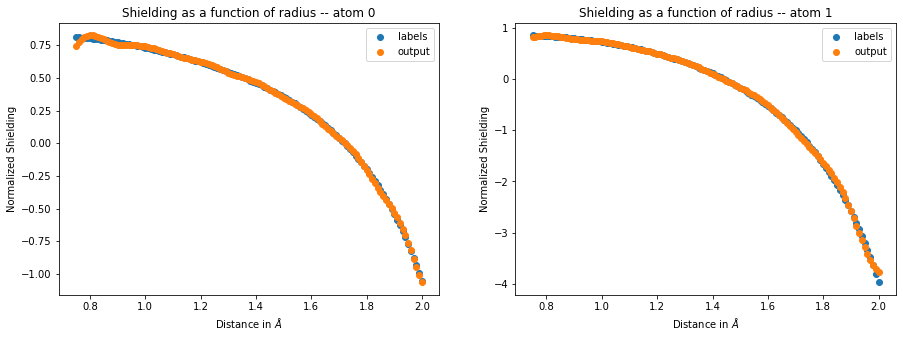

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for i, ax in enumerate(axes):
    ax.set_title("Shielding as a function of radius -- atom {}".format(i))
    ax.set_ylabel('Normalized Shielding')
    ax.set_xlabel('Distance in $\AA$')
    ax.plot(dists, shielding[:, i], 'o', label='labels')
    ax.plot(dists, output[:, i].detach(), 'o', label='output')
    ax.legend()